In [10]:
import pandas as pd

def load_data(file_path):
    """加载CSV数据并处理可能的异常"""
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：文件 {file_path} 未找到")
        exit()
    except Exception as e:
        print(f"加载数据时发生错误: {str(e)}")
        exit()

def analyze_country_athletes(data, countries):
    """分析各国运动员数据并返回结构化结果"""
    results = {}
    for country in countries:
        # 过滤国家数据
        country_data = data[data['NOC'] == country].copy()
        
        # 处理可能的空数据
        if country_data.empty:
            print(f"警告：未找到国家代码 {country} 的数据")
            continue
            
        # 执行分组计算
        analysis = country_data.groupby('Sport').agg(
            Medal_Counts=pd.NamedAgg(column='Medal', aggfunc=lambda x: (x != 'No medal').sum()),
            Unique_Athletes=pd.NamedAgg(column='Name', aggfunc='nunique')
        )
        
        # 计算奖牌效率（添加epsilon防止除零）
        epsilon = 1e-6  # 极小值处理零运动员情况
        analysis['Medal_Efficiency'] = analysis['Medal_Counts'] / (analysis['Unique_Athletes'] + epsilon)
        
        # 格式化排序结果
        results[country] = analysis.sort_values('Unique_Athletes', ascending=False).reset_index()
    
    return results

def save_results(results, output_dir="results"):
    """将结果保存为CSV文件"""
    import os
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    
    # 为每个国家生成CSV
    for country, df in results.items():
        filename = f"{output_dir}/{country}_analysis.csv"
        df.to_csv(filename, index=False)
        print(f"已保存 {filename}")

def main():
    # 配置参数
    file_path = 'summerOly_athletes.csv'
    target_countries = ['CHN', 'USA', 'GER']
    
    # 数据加载
    data = load_data(file_path)
    
    # 执行分析
    results = analyze_country_athletes(data, target_countries)
    
    # 保存结果
    save_results(results)
    
    # 控制台预览
    print("\n数据预览:")
    for country, df in results.items():
        print(f"\n{country} 分析结果:")
        print(df.head())

if __name__ == "__main__":
    main()

已保存 results/CHN_analysis.csv
已保存 results/USA_analysis.csv
已保存 results/GER_analysis.csv

数据预览:

CHN 分析结果:
        Sport  Medal_Counts  Unique_Athletes  Medal_Efficiency
0   Athletics            36              402          0.089552
1    Swimming           120              238          0.504202
2  Basketball            23              167          0.137725
3    Shooting            81              159          0.509434
4      Rowing            44              151          0.291391

USA 分析结果:
        Sport  Medal_Counts  Unique_Athletes  Medal_Efficiency
0   Athletics          1190             2048          0.581055
1    Swimming          1206              765          1.576471
2      Rowing           388              710          0.546479
3   Wrestling           144              339          0.424779
4  Gymnastics           194              314          0.617834

GER 分析结果:
       Sport  Medal_Counts  Unique_Athletes  Medal_Efficiency
0  Athletics           165              887          0.

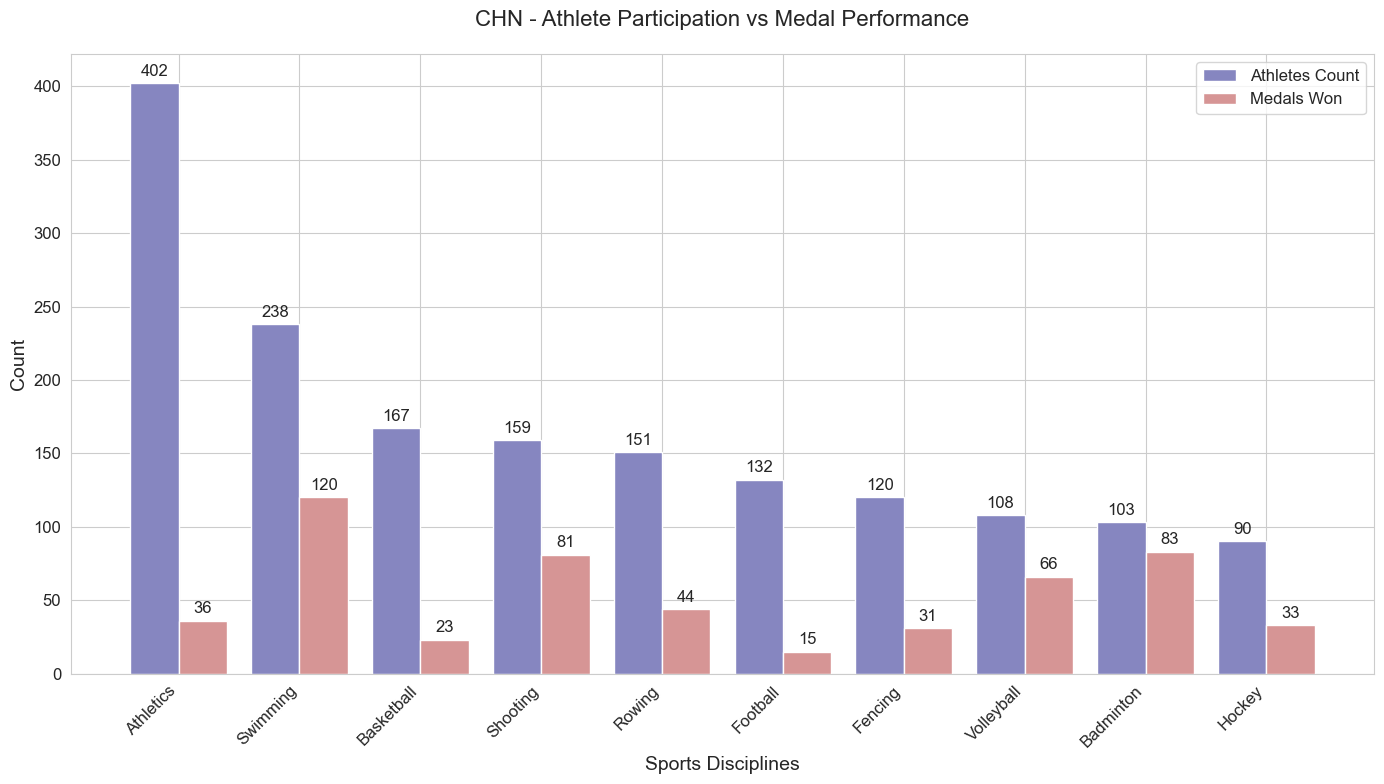

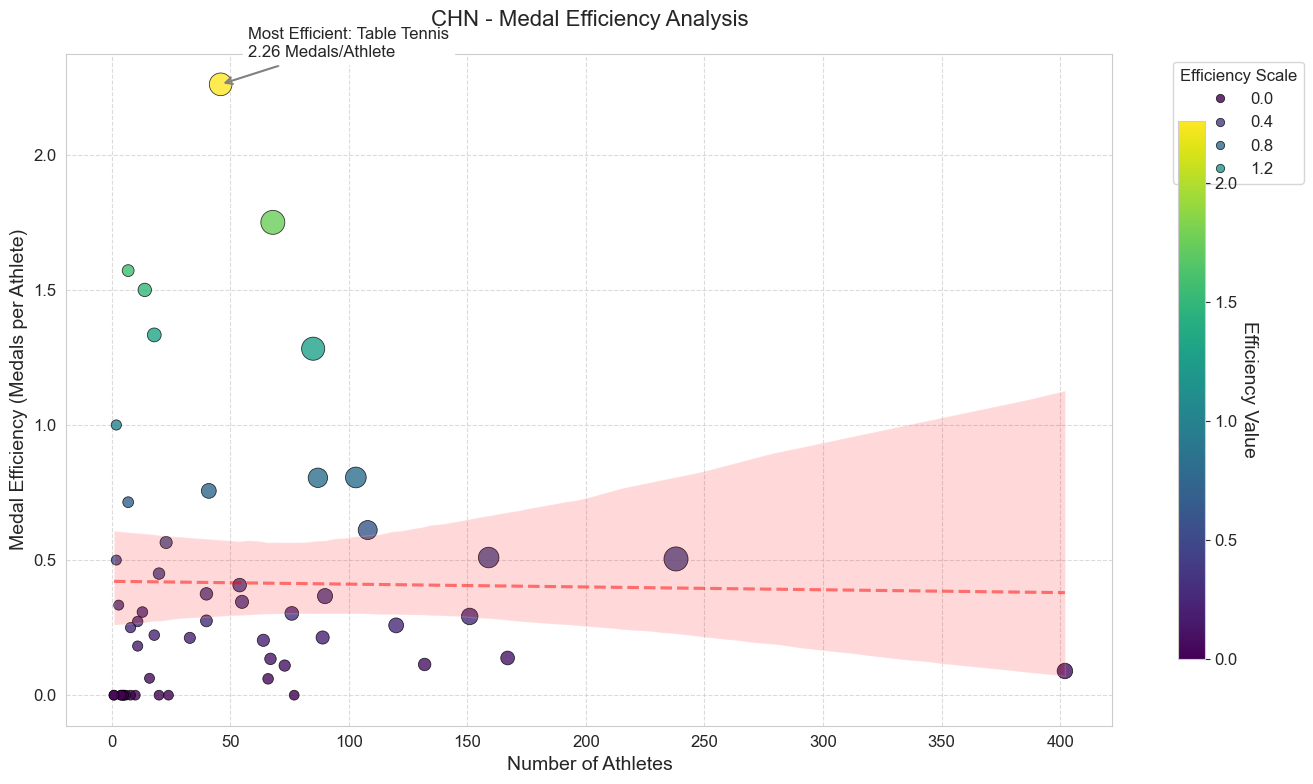

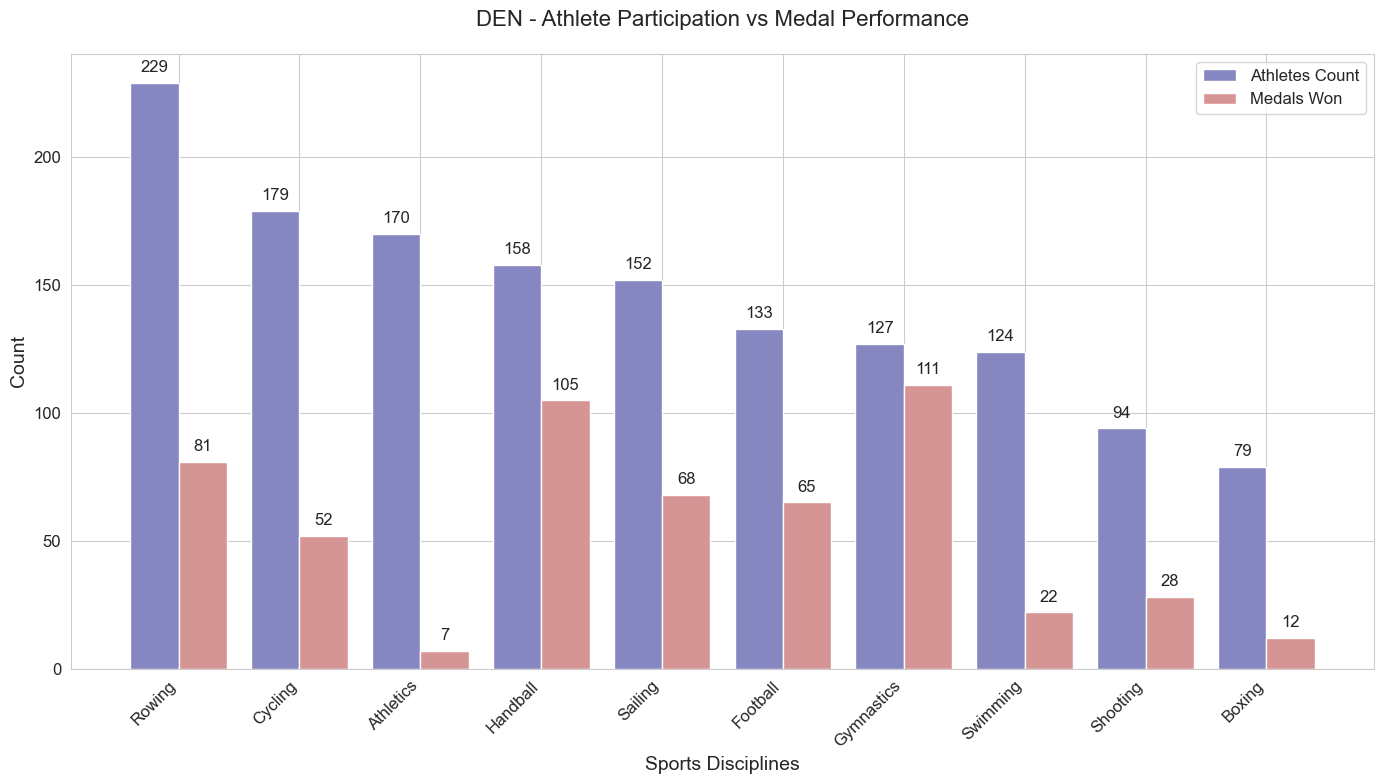

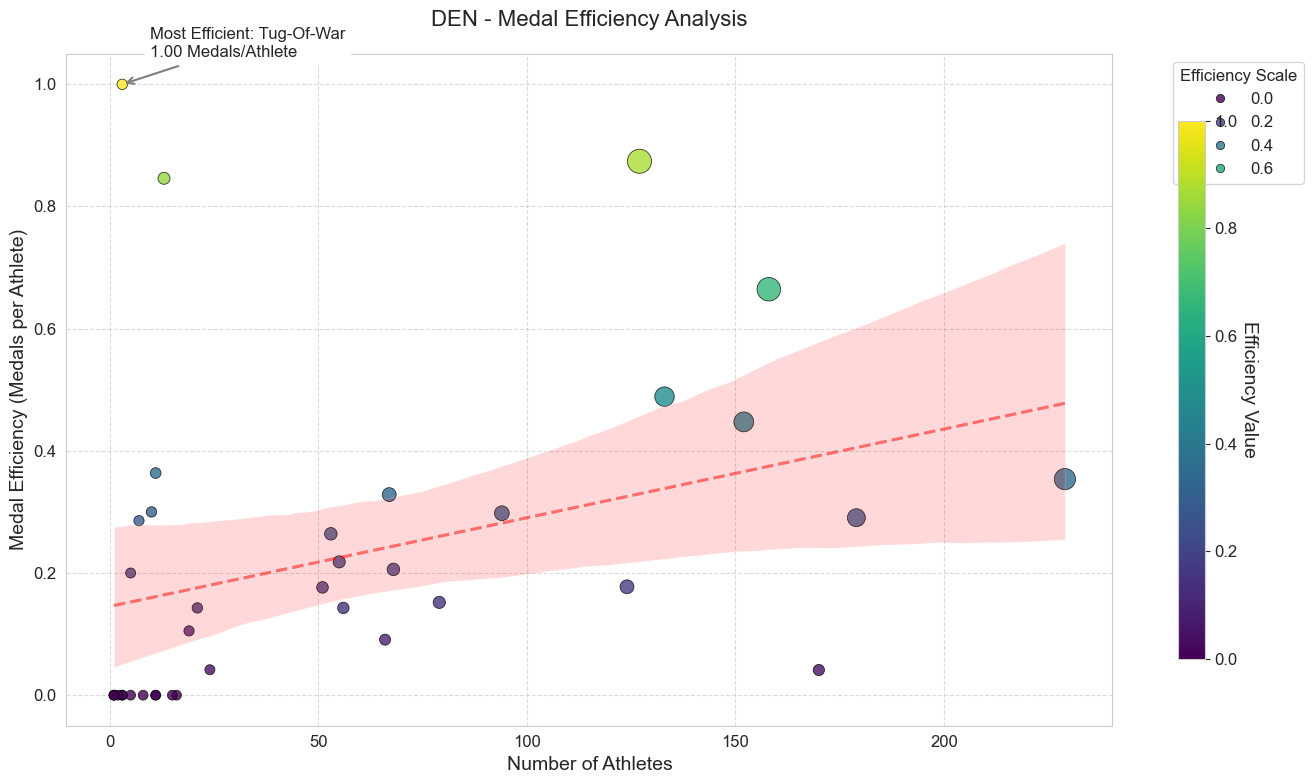

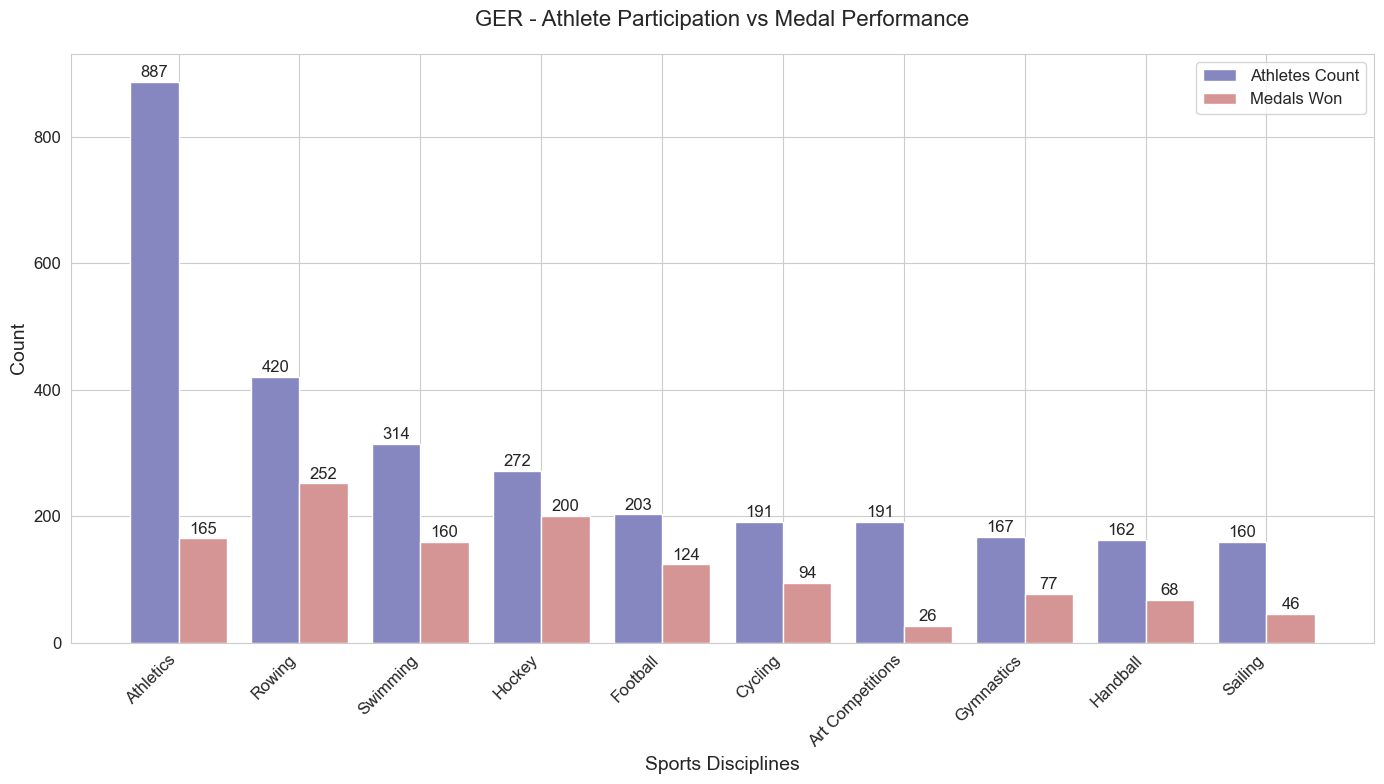

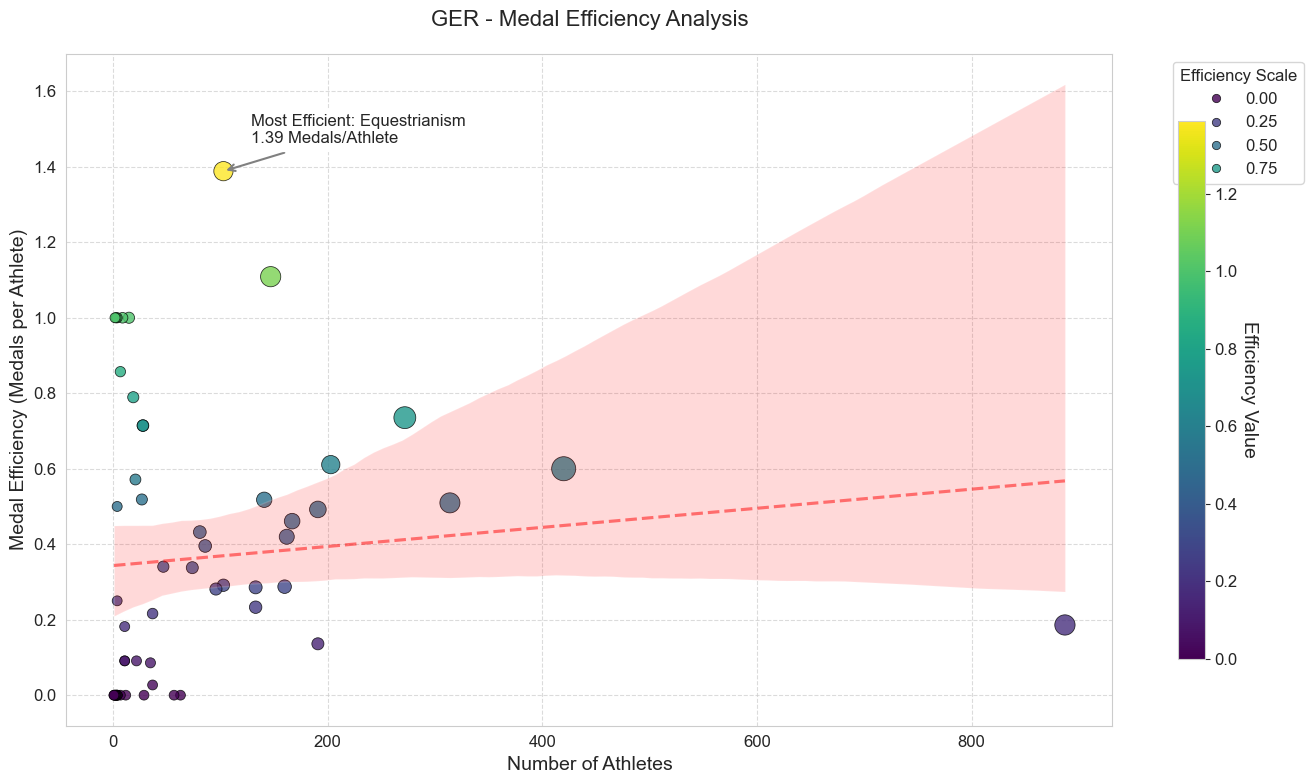

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def load_data(file_path):
    """Load Olympic dataset"""
    return pd.read_csv(file_path)

def analyze_country_athletes(data, countries):
    """Analyze athlete data and medal efficiency by country"""
    results = {}
    for country in countries:
        country_data = data[data['NOC'] == country]
        analysis = country_data.groupby('Sport').agg({
            'Medal': lambda x: (x != 'No medal').sum(),
            'Name': 'nunique'
        }).rename(columns={
            'Medal': 'Medal Counts',
            'Name': 'Unique Athletes'
        })
        
        analysis['Medal Efficiency'] = analysis['Medal Counts'] / analysis['Unique Athletes']
        results[country] = analysis.sort_values('Unique Athletes', ascending=False)
    return results

def plot_results(results):
    """Visualize analysis results with English annotations"""
    for country, data in results.items():
        # Prepare data
        top_sports = data.head(10).reset_index()
        
        # ========== Athletes vs Medals Comparison ==========
        plt.figure(figsize=(14, 8))
        bar_width = 0.4
        x = np.arange(len(top_sports))
        
        # Create dual bar chart
        bars1 = plt.bar(x - bar_width/2, top_sports['Unique Athletes'], 
                       bar_width, label='Athletes Count',
                       color=sns.light_palette("navy", n_colors=10)[4])
        bars2 = plt.bar(x + bar_width/2, top_sports['Medal Counts'], 
                       bar_width, label='Medals Won',
                       color=sns.light_palette("firebrick", n_colors=10)[4])

        # Chart styling
        plt.title(f'{country} - Athlete Participation vs Medal Performance', pad=20)
        plt.xticks(x, top_sports['Sport'], rotation=45, ha='right')
        plt.xlabel('Sports Disciplines')
        plt.ylabel('Count')
        plt.legend()
        
        # Add value labels
        for bars in (bars1, bars2):
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height+3,
                        f'{height:.0f}',
                        ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # ========== Medal Efficiency Analysis ==========
        plt.figure(figsize=(14, 8))
        
        # Create scatter plot
        scatter = sns.scatterplot(
            x='Unique Athletes', 
            y='Medal Efficiency',
            data=data.reset_index(),
            hue='Medal Efficiency',
            palette='viridis',
            size='Medal Counts',
            sizes=(50, 300),
            alpha=0.8,
            edgecolor='black',
            legend='brief'
        )
        
        # Add regression line
        sns.regplot(
            x='Unique Athletes', 
            y='Medal Efficiency',
            data=data.reset_index(),
            scatter=False,
            color='red',
            line_kws={'linestyle':'--', 'alpha':0.5}
        )

        # Highlight top performer
        max_eff = data['Medal Efficiency'].idxmax()
        max_data = data.loc[max_eff]
        plt.annotate(
            f"Most Efficient: {max_eff}\n{max_data['Medal Efficiency']:.2f} Medals/Athlete",
            xy=(max_data['Unique Athletes'], max_data['Medal Efficiency']),
            xytext=(20, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='grey', linewidth=1.5),
            bbox=dict(boxstyle="round", fc="w")
        )

        # Chart styling
        plt.title(f'{country} - Medal Efficiency Analysis', pad=20)
        plt.xlabel('Number of Athletes')
        plt.ylabel('Medal Efficiency (Medals per Athlete)')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Customize legend
        handles, labels = scatter.get_legend_handles_labels()
        plt.legend(handles[1:5], labels[1:5], 
                 title='Efficiency Scale', 
                 bbox_to_anchor=(1.05, 1), 
                 loc='upper left')

        # Add color bar
        norm = plt.Normalize(data['Medal Efficiency'].min(), data['Medal Efficiency'].max())
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter.axes, shrink=0.8)
        cbar.set_label('Efficiency Value', rotation=270, labelpad=15)

        plt.tight_layout()
        plt.show()

def main():
    # Data path
    file_path = 'summerOly_athletes.csv'
    
    # Load data
    olympic_data = load_data(file_path)
    
    # Target countries
    target_countries =  ["CHN", "DEN", "GER"] 
    
    # Perform analysis
    analysis_results = analyze_country_athletes(olympic_data, target_countries)
    
    # Generate visualizations
    plot_results(analysis_results)

if __name__ == "__main__":
    main()

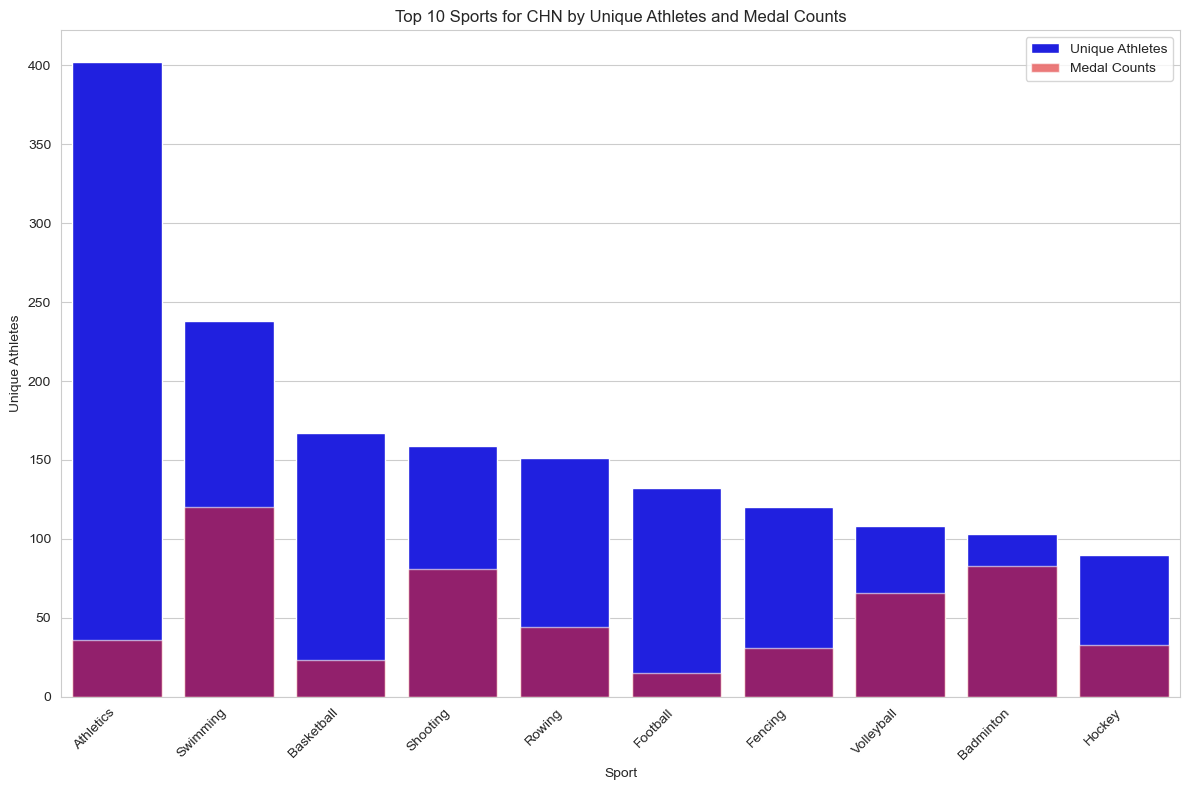

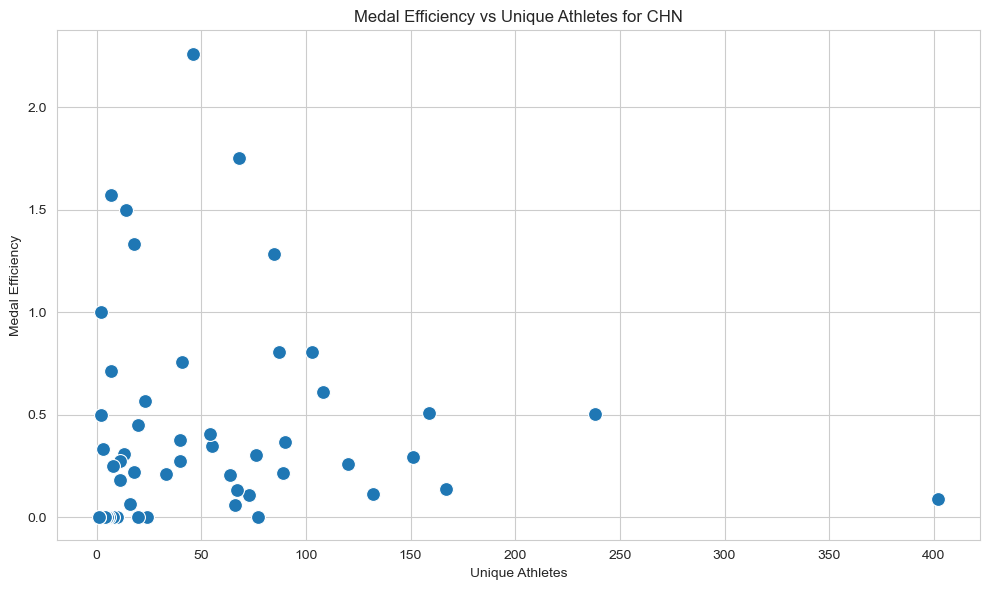

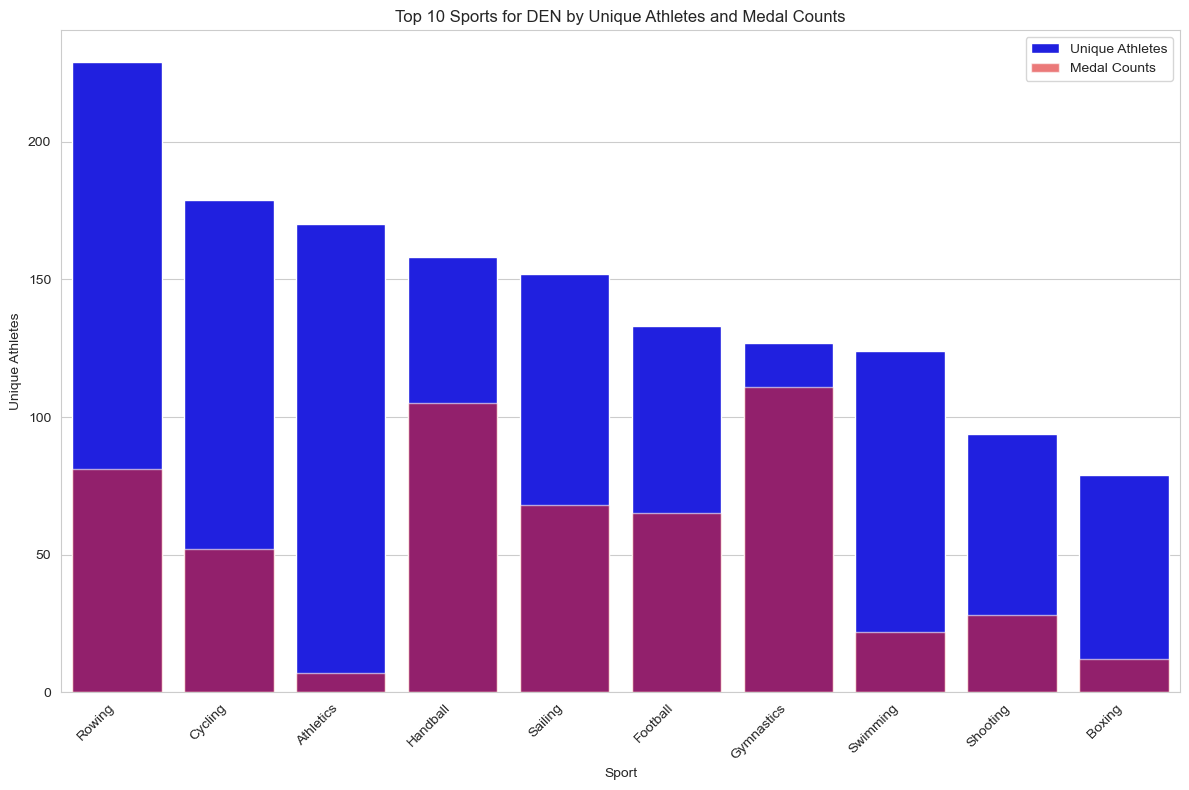

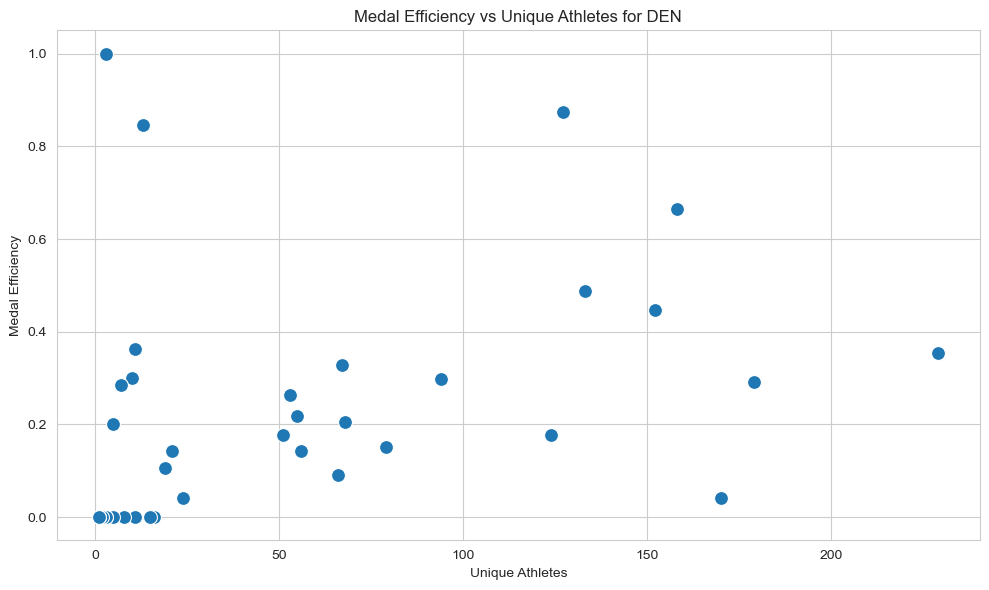

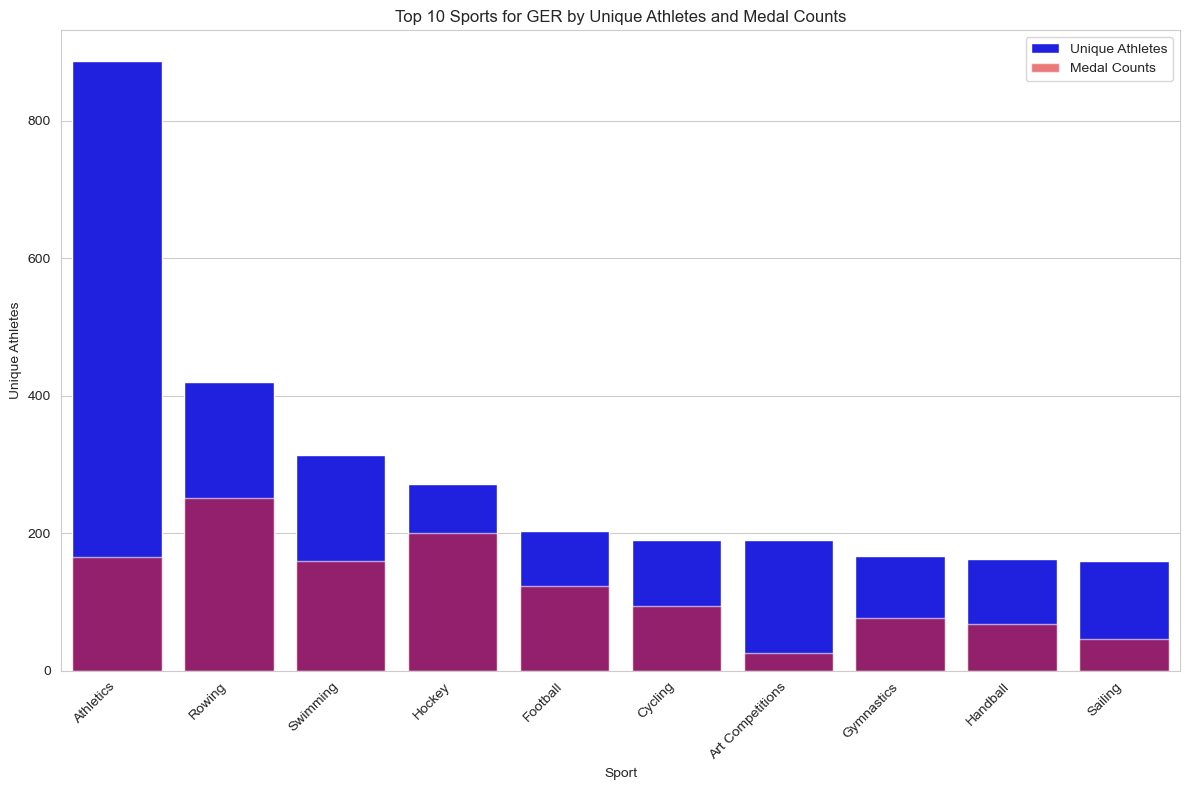

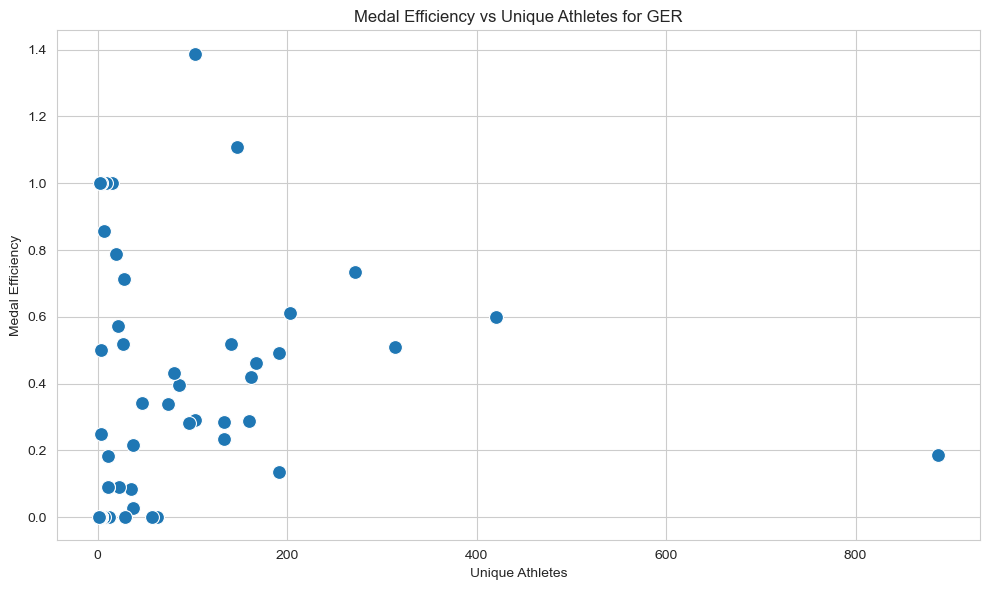

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
def load_data(file_path):
    return pd.read_csv(file_path)

# 分析各国运动员数据
def analyze_country_athletes(data, countries):
    results = {}
    for country in countries:
        country_data = data[data['NOC'] == country]
        analysis = country_data.groupby('Sport').agg({
            'Medal': lambda x: (x != 'No medal').sum(),
            'Name': 'nunique'
        }).rename(columns={"Medal": 'Medal Counts', 'Name': 'Unique Athletes'})
        
        analysis['Medal Efficiency'] = analysis['Medal Counts'] / analysis['Unique Athletes']
        results[country] = analysis.sort_values('Unique Athletes', ascending=False)
    return results

# 绘制结果
def plot_results(results):
    for country, data in results.items():
        # 只显示前10个项目
        top_sports = data.head(10)
        
        # 绘制图: 运动员数量与奖牌数量
        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_sports.index, y='Unique Athletes', data=top_sports, color='blue', label='Unique Athletes')
        sns.barplot(x=top_sports.index, y='Medal Counts', data=top_sports, color='red', alpha=0.6, label='Medal Counts')
        plt.title(f'Top 10 Sports for {country} by Unique Athletes and Medal Counts')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 绘制图: 奖牌效率与运动员数量
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Unique Athletes', y='Medal Efficiency', data=data, s=100)
        plt.title(f'Medal Efficiency vs Unique Athletes for {country}')
        plt.xlabel('Unique Athletes')
        plt.ylabel('Medal Efficiency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
def main():
    # 文件路径
    file_path = 'summerOly_athletes.csv'
    data = load_data(file_path)

    # 指定国家
    countries = ["CHN","DEN", "GER"]  # 添加更多国家代码
    results = analyze_country_athletes(data, countries)

    # 绘制图表
    plot_results(results)

if __name__ == "__main__":
    main()
